<a href="https://colab.research.google.com/github/haythemtellili/Great-notebook/blob/master/Time_series_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usefull sources:
[ARIMA/PROPHET](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

[Stats and theorical part](https://www.youtube.com/watch?v=DeORzP0go5I&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=1)

# LSTM Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/AirPassengers.csv')
df.head()

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [0]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

In [4]:
df.shape

(144, 1)

In [0]:
train, test = df[:-12], df[-12:]

In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [0]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [0]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.fit_generator(generator,epochs=90)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/90





20/20 [==============================] - 10s 476ms/step - loss: 0.0793
Epoch 2/90
20/20 [==============================] - 1s 28ms/step - loss: 0.0204
Epoch 3/90
20/20 [==============================] - 1s 28ms/step - loss: 0.0178
Epoch 4/90
20/20 [==============================] - 1s 29ms/step - loss: 0.0106
Epoch 5/90
20/20 [==============================] - 1s 27ms/step - loss: 0.0124
Epoch 6/90
20/20 [==============================] - 1s 29ms/step - loss: 0.0104
Epoch 7/90
20/20 [==============================] - 1s 28ms/step - loss: 0.0099
Epoch 8/90
20/20 [==============================] - 1s 29ms/step - loss: 0.0099
Epoch 9/90
20/20 [==============================] - 1s 29ms/step - loss: 0.0094
Epoch 10/90
20/20 [==============================] - 1s 28ms/step - loss: 0.0097
Epoch 11/90
20/20 [==============================] - 1s 28ms/step - loss: 0.0086
Epoch 12/90
20

In [0]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [0]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])
data = pd.concat([df,df_predict], axis=1)

No handles with labels found to put in legend.


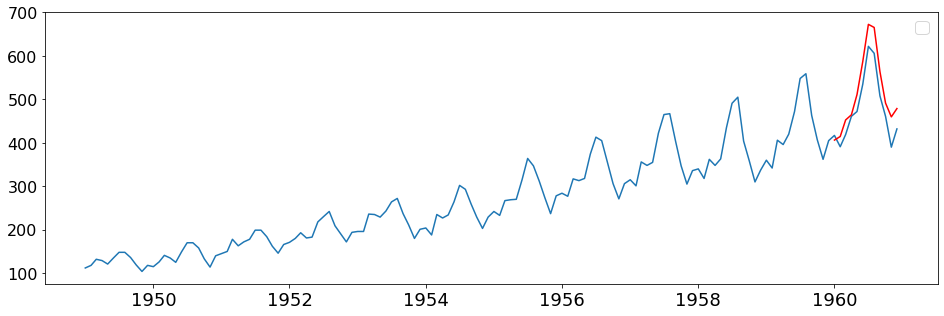

In [0]:
plt.figure(figsize=(16, 5))
plt.plot(data.index, data['AirPassengers'])
plt.plot(data.index, data['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

# SARIMAX Model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
%matplotlib inline

In [8]:
dataset = pd.read_csv('/content/AirPassengers.csv')
dataset.head()

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [0]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index('Month', inplace=True)
dataset.index.freq = 'MS'

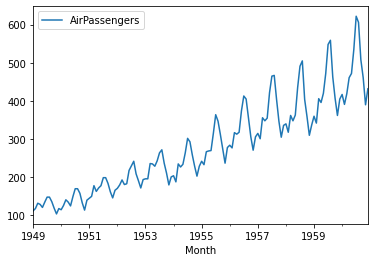

In [10]:
dataset.plot()

In [0]:
train, test = dataset.iloc[:131], dataset.iloc[131:]

In [0]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [13]:
best = find_best_sarima(train, 'aic')
best

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'aic': 793.9172538749697,
 'bic': 804.4948174715352,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fb0f60cbf98>,
 'order': (0, 1, 1),
 'seasonal_order': (1, 1, 1, 12)}

In [0]:
pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

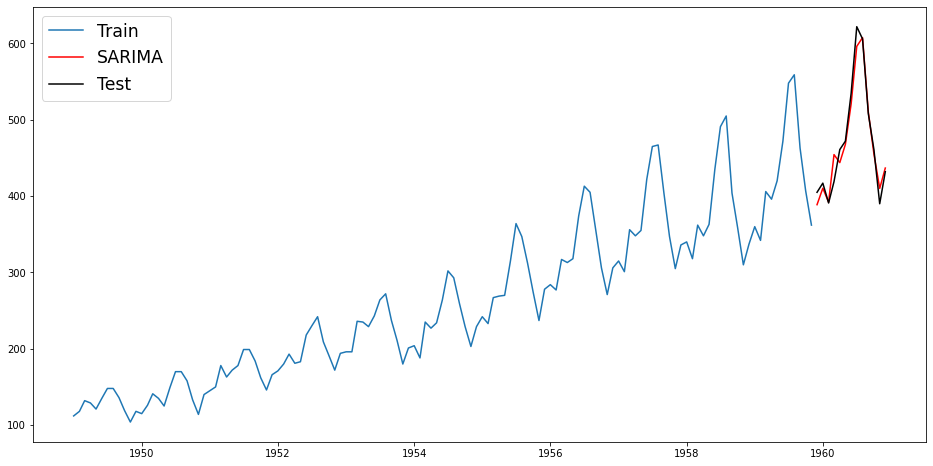

In [16]:
plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(pred.index, pred, label='SARIMA', color='r')
plt.plot(test.index, test, label='Test', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

# Stock price prediction

In [17]:
!unzip "/content/drive/My Drive/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master.zip"

Archive:  /content/drive/My Drive/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master.zip
6918aaafb1b11e5087b8424e1a50f4028268a4ea
   creating: Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/
  inflating: Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/Google_Stock_Price_Test.csv  
  inflating: Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/Google_Stock_Price_Train.csv  
  inflating: Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/README.md  
  inflating: Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/rnn.py  


In [18]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
data=pd.read_csv('/content/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/Google_Stock_Price_Train.csv')
test=pd.read_csv('/content/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ-master/Google_Stock_Price_Test.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [0]:
train=data[['Date','Open']]
test=test[['Date','Open']]

In [0]:
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index("Date")
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83
2012-01-06,328.34
2012-01-09,322.04


In [0]:
test['Date'] = pd.to_datetime(test['Date'])
test = test.set_index("Date")
test.head()

,Open
Date,
2017-01-03,778.81
2017-01-04,788.36
2017-01-05,786.08
2017-01-06,795.26
2017-01-09,806.40


In [0]:
train.shape,test.shape

((1258, 1), (20, 1))

In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [0]:
n_input = 20
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [0]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)

Epoch 1/10
207/207 [==============================] - 12s 57ms/step - loss: 0.0223
Epoch 2/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0030
Epoch 3/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0026
Epoch 4/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0032
Epoch 5/10
207/207 [==============================] - 11s 54ms/step - loss: 0.0025
Epoch 6/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0024
Epoch 7/10
207/207 [==============================] - 11s 54ms/step - loss: 0.0022
Epoch 8/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0019
Epoch 9/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0019
Epoch 10/10
207/207 [==============================] - 11s 53ms/step - loss: 0.0022


In [0]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [0]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                           columns=['Prediction'])

In [0]:
df_predict.head(30)

,Prediction
0,766.019155
1,760.930616
2,755.754188
3,750.500734
4,745.221391
5,739.964348
6,734.765620
7,729.638599
8,724.598410
9,719.644668


# SARIMAX Model


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [47]:
dataset=pd.read_csv('/content/AAPL.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-01,15.988571,16.051428,15.341429,15.588572,13.531516,324121000
1,2008-10-02,15.430000,15.541429,14.285714,14.300000,12.412984,402341100
2,2008-10-03,14.857142,15.214286,13.521428,13.867143,12.037247,573599600
3,2008-10-06,13.137143,14.111428,12.505714,14.020000,12.169932,526854300
4,2008-10-07,14.354285,14.500000,12.707143,12.737143,11.056362,469693000


In [48]:
dataset.shape

(2768, 7)

In [49]:
dataset["Mean"] = (dataset['Low'] + dataset['High'])/2
dataset.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2008-10-01,15.988571,16.051428,15.341429,15.588572,13.531516,324121000,15.696429
1,2008-10-02,15.430000,15.541429,14.285714,14.300000,12.412984,402341100,14.913572


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 8 columns):
Date         2768 non-null object
Open         2768 non-null float64
High         2768 non-null float64
Low          2768 non-null float64
Close        2768 non-null float64
Adj Close    2768 non-null float64
Volume       2768 non-null int64
Mean         2768 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 173.1+ KB


In [51]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,2008-10-01,15.988571,16.051428,15.341429,15.588572,13.531516,324121000,15.696429,14.913572
1,2008-10-02,15.430000,15.541429,14.285714,14.300000,12.412984,402341100,14.913572,14.367857
2,2008-10-03,14.857142,15.214286,13.521428,13.867143,12.037247,573599600,14.367857,13.308571


In [0]:
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']

In [53]:
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
Date,,,,,,,,,
2008-10-01,2008-10-01,15.988571,16.051428,15.341429,15.588572,13.531516,324121000,15.696429,14.913572
2008-10-02,2008-10-02,15.430000,15.541429,14.285714,14.300000,12.412984,402341100,14.913572,14.367857
2008-10-03,2008-10-03,14.857142,15.214286,13.521428,13.867143,12.037247,573599600,14.367857,13.308571


Text(0.5, 1.0, 'Tyson Opening Stock Value')

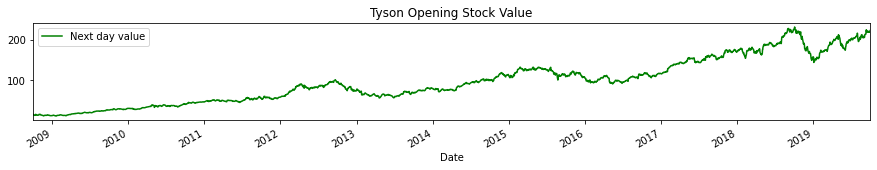

In [54]:
dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value','Mean'])
plt.title("Tyson Opening Stock Value")




In [0]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open','Close','Volume','Adj Close','Mean',]])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [0]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [88]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X.index=dataset_for_prediction.index

X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2008-10-01,0.019075,0.019558,0.021177,0.019996,0.556275,0.01762,0.019318
2008-10-02,0.014246,0.017258,0.018632,0.014163,0.695398,0.01248,0.015763


In [89]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
Date,
2008-10-01,0.015763
2008-10-02,0.013284


In [0]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset))-train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [91]:
train_X.head()

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2008-10-01,0.019075,0.019558,0.021177,0.019996,0.556275,0.017620,0.019318
2008-10-02,0.014246,0.017258,0.018632,0.014163,0.695398,0.012480,0.015763
2008-10-03,0.010750,0.015783,0.016021,0.012203,1.000000,0.010753,0.013284
2008-10-06,0.006104,0.010810,0.008183,0.012895,0.916858,0.011363,0.008474
2008-10-07,0.007025,0.012562,0.013730,0.007088,0.815191,0.006246,0.009813


In [92]:
!pip install pmdarima
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-15584.598, BIC=-15523.346, Time=5.813 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-15557.800, BIC=-15507.685, Time=0.835 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-15572.044, BIC=-15516.360, Time=3.323 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-15571.535, BIC=-15515.851, Time=1.811 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-15557.479, BIC=-15512.932, Time=2.133 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-15612.080, BIC=-15545.260, Time=5.659 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-15620.094, BIC=-15558.842, Time=6.086 seconds
Fit ARIMA: (3, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-15600.103, BIC=-15533.282, Time=6.489 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-15565.803, BIC=-15493.414, Time=2.956 seconds
Total fit time: 35.117 seconds


In [93]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1937
Model:               SARIMAX(2, 1, 0)   Log Likelihood                7821.047
Date:                Tue, 17 Mar 2020   AIC                         -15620.094
Time:                        21:33:45   BIC                         -15558.842
Sample:                             0   HQIC                        -15597.567
                               - 1937                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.782      0.075   -1.95e-05       0.000
Low           -0.0090      0.026     -0.347      0.729      -0.060       0.042
High          -0.0659      0.030     -2.183      0.029      -0.125      -0.007
Open          -0.0814      0.028     -2.953      0.003      -0.135      -0.027
Close          0.7811      0.369      2.119      0.034       0.059       1.503
Volume         0.0006      0.001      0.445      0.656      -0.002       0.003
Adj Close     -0.0833      0.392     -0.213      0.831      -0.851       0.684
Mean          -0.0376      0.020     -1.849      0.064      -0.078       0.002
ar.L1         -0.3746      0.038     -9.938      0.000      -0.448      -0.301
ar.L2         -0.0905      0.032     -2.823      0.005      -0.153      -0.028
sigma2      1.839e-05   2.24e-07     81.944      0.000    1.79e-05    1.88e-05
===================================================================================
Ljung-Box (Q):                       59.81   Jarque-Bera (JB):             16881.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               7.40   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.4e+17. Standard errors may be unstable.
"""

In [86]:
train_y.head()

,Stock Price next day
Date,
2008-10-01,0.015763
2008-10-02,0.013284
2008-10-03,0.008474
2008-10-06,0.009813
2008-10-07,0.007075


In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(train_y, 
 exog=train_X,
 order=(2,1,0),
 enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
results= model.fit()

In [101]:
test_X.head()

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2016-06-13,0.393070,0.394153,0.398055,0.390082,0.047415,0.377278,0.393616
2016-06-14,0.391469,0.391267,0.391812,0.390625,0.036586,0.377798,0.391368
2016-06-15,0.392750,0.390951,0.394090,0.389177,0.032163,0.376411,0.391844
2016-06-16,0.388359,0.387975,0.387847,0.391033,0.035510,0.378188,0.388166
2016-06-17,0.384837,0.383015,0.388622,0.380983,0.088301,0.368567,0.383919


In [116]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X[:830])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [121]:
predictions.shape,test_X.shape

((830,), (830, 7))

In [0]:
test_X=test_X[:830]

In [0]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [0]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

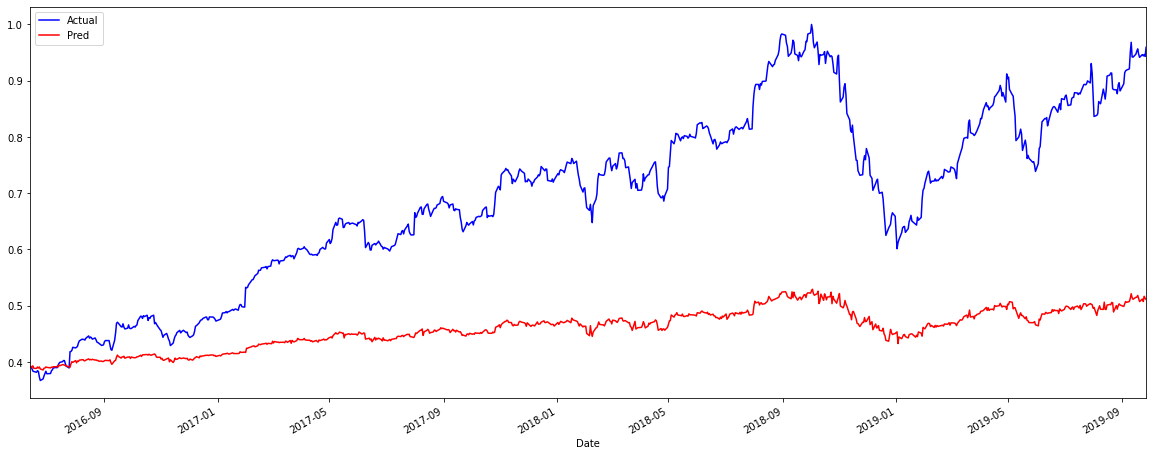

In [127]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))